In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input, Concatenate, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#Sarcasm Detection using Deep Learning

In [ ]:
df = pd.read_csv('Small.csv', index_col=False)
texts = df['Tweet']
labels = df['Sarcasm'].map({'yes': 1, 'no': 0})

##Data Selection and Preprocessing

In [ ]:
df.head()

,Tweet,Sarcasm
0,Fantastic service yet again from EE. 1st you u...,yes
1,Not sure if that was or. I will take it! face_...,yes
2,Barely 9 am and already shaking with rage.,yes
3,I guess that proves it then. Black folks have ...,yes
4,Does this tweet need a tag,yes


In [ ]:
df.tail()

,Tweet,Sarcasm
6925,just home from uni and im knackered have no en...,no
6926,as we have been approved by god to be entruste...,no
6927,i love these boys so much and id be so gratefu...,yes
6928,if youre in ny wed love to have you speak on w...,no
6929,i learned so much chatting w u today thank you...,no


In [ ]:
df.shape

(6930, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6930 entries, 0 to 6929
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    6930 non-null   object
 1   Sarcasm  6930 non-null   object
dtypes: object(2)
memory usage: 108.4+ KB


In [ ]:
df.isnull().sum()

Tweet      0
Sarcasm    0
dtype: int64

##Word Tokenization

In [ ]:
!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

In [ ]:
tokenizer = TweetTokenizer()

def tokenize_text(Tweet):
    if not isinstance(Tweet, str):
        return []
    return tokenizer.tokenize(Tweet)


df = pd.read_csv('Small.csv')
df['tokens'] = df['Tweet'].apply(tokenize_text)

print(df.head(15))
df.to_csv('Small.csv', index=False)

                                                Tweet Sarcasm  \
0   Fantastic service yet again from EE. 1st you u...     yes   
1   Not sure if that was or. I will take it! face_...     yes   
2          Barely 9 am and already shaking with rage.     yes   
3   I guess that proves it then. Black folks have ...     yes   
4                          Does this tweet need a tag     yes   
5   both. Wont be using you again. Made a formal c...     yes   
6                Fuuuuuuuuck this shit screams thug!!     yes   
7   66 UEs from Staniel and he wins in straights. ...     yes   
8              totally surprising to every husker fan     yes   
9                     Haha got to love the enthusiasm     yes   
10  a southern pride advocate but of course it has...     yes   
11  So nice not hearing any rumors that the  are n...     yes   
12  We should divide illegals into two lines one f...     yes   
13      does not even look like that great of a view.     yes   
14  Mondays are always dr

##TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tweets = df['Tweet'].fillna('')
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(tweets)
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
final_df = pd.concat([df.drop('Tweet', axis=1), tfidf_df], axis=1)
final_df.to_csv("Small.csv", index=False)

##Checking for Imbalances

In [ ]:
y = df['Sarcasm']
y.value_counts()

Sarcasm
yes    3633
no     3297
Name: count, dtype: int64

<Axes: ylabel='count'>

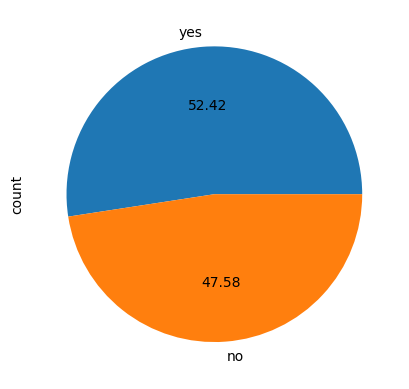

In [ ]:
y.value_counts().plot.pie(autopct='%.2f')

##Balancing of the Imbalanced Dataset

In [ ]:
!pip install imblearn
from imblearn.over_sampling import SMOTE

### Random Oversampling
Random oversampling is a technique in machine learning to address imbalanced datasets by randomly duplicating instances from the minority class. This balances the dataset and helps improve the model's ability to predict the minority class accurately

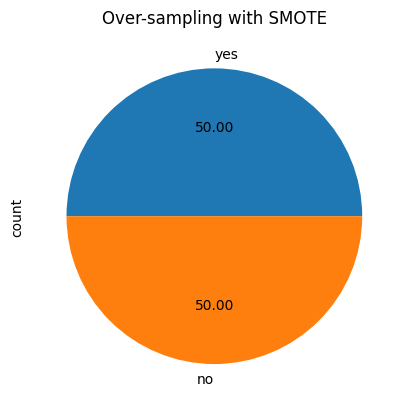

In [ ]:
tfidf = TfidfVectorizer()
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['Tweet'])
y = df['Sarcasm']
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)
ax = y_resampled.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling with SMOTE")
plt.show()

##Making the Prediction Function

In [ ]:
def predict_sarcasm(text, tokenizer, model, max_len):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    prediction = model.predict(padded_sequence)
    if prediction > 0.5:
        return "This text is predicted to be sarcastic."
    else:
        return "This text is predicted to be non-sarcastic."

##CNN(Convolutional Neural Network)

Define parameters

In [ ]:
max_len = 128
vocab_size = 10000
embedding_dim = 512
filter_sizes = [3, 4, 5]
num_filters = 40
dropout_rate1 = 0.2
l2_lambda = 0.01


texts = df['Tweet'].astype(str)
labels = df['Sarcasm']
labels = df['Sarcasm'].map({'yes': 1, 'no': 0})

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len)

Split the dataset into Train, Test, and Validation sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
train_size = len(X_train_val)
test_size = len(X_test)
val_size = len(X_val)
sizes = [train_size, test_size, val_size]
dataset_labels = ['Train', 'Test', 'Validation']

Plot Dataset sizes

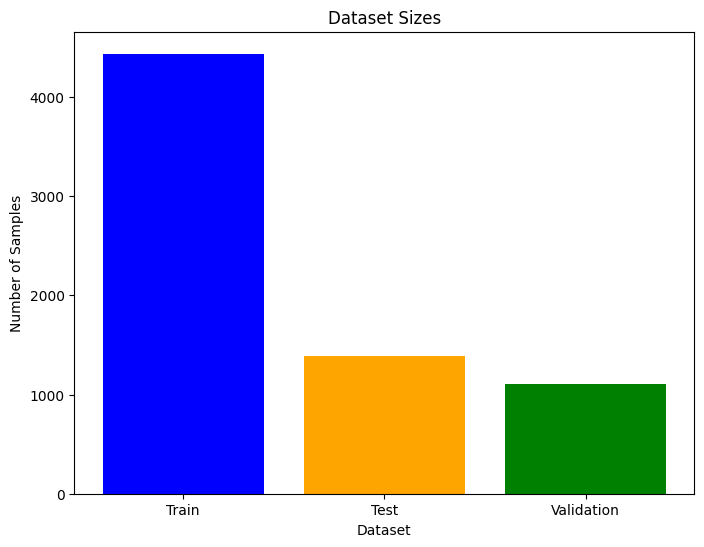

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(dataset_labels, sizes, color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Dataset Sizes')
plt.show()

Label-wise Split in Train Data

In [ ]:
label_counts = pd.Series(y_train_val).value_counts()

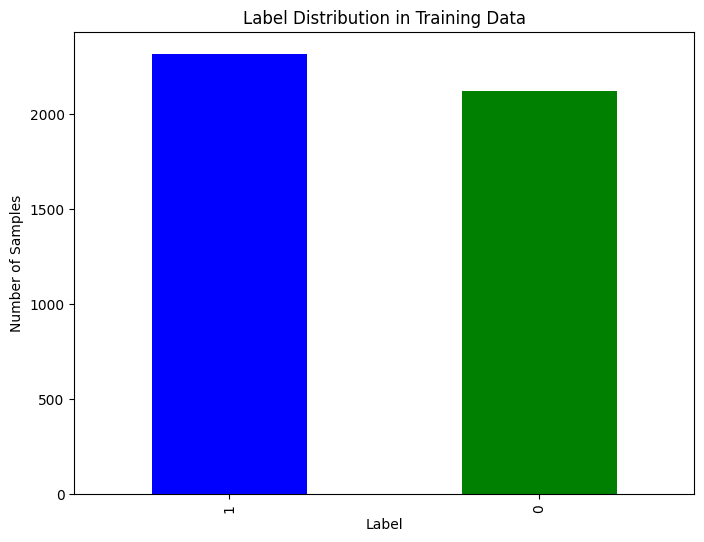

In [ ]:
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'green'])
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Label Distribution in Training Data')
plt.show()

Plot Label distribution (Pie Chart)

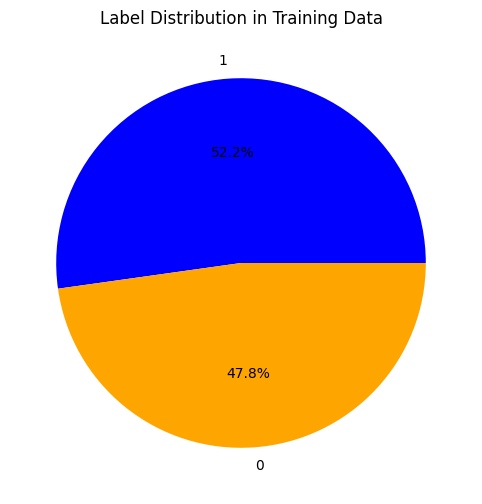

In [ ]:
plt.figure(figsize=(8, 6))
label_counts.plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'orange'])
plt.ylabel('')
plt.title('Label Distribution in Training Data')
plt.show()

Define the CNN model

In [ ]:
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_len)(input_layer)

conv_layers = []
for filter_size in filter_sizes:
    conv_layer = Conv1D(num_filters, filter_size, activation='tanh', padding='same')(embedding_layer)
    gated_conv_layer = Conv1D(num_filters, filter_size, activation='sigmoid', padding='same')(conv_layer)
    drop_layer = Dropout(dropout_rate1)(gated_conv_layer)
    pooled_layer = GlobalMaxPooling1D()(drop_layer)
    conv_layers.append(pooled_layer)

merged_layer = Concatenate()(conv_layers)
dense_layer1 = Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda))(merged_layer)
dropout_layer1 = Dropout(dropout_rate1)(dense_layer1)
dropout_layer3 = Dropout(dropout_rate1)(dense_layer1)

lstm_layer = (LSTM(1024, return_sequences=False))(embedding_layer)
lstm_layer2 = (LSTM(512, return_sequences=False))(embedding_layer)
lstm_layer3 = (LSTM(256, return_sequences=False))(embedding_layer)
lstm_layer4 = (LSTM(128, return_sequences=False))(embedding_layer)
lstm_layer5 = (LSTM(64, return_sequences=False))(embedding_layer)


concat_layer = Concatenate()([dropout_layer1, lstm_layer, lstm_layer2, lstm_layer3, lstm_layer4, lstm_layer5])

dense_layer2 = Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda))(concat_layer)
dropout_layer2 = Dropout(dropout_rate1)(dense_layer1)
output_layer = Dense(1, activation='sigmoid')(dropout_layer2)


model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/10
174/174 [==============================] - 58s 319ms/step - loss: 0.9505 - accuracy: 0.8120 - val_loss: 0.5383 - val_accuracy: 0.8838
Epoch 2/10
174/174 [==============================] - 58s 333ms/step - loss: 0.3486 - accuracy: 0.9280 - val_loss: 0.3736 - val_accuracy: 0.8954
Epoch 3/10
174/174 [==============================] - 54s 310ms/step - loss: 0.1478 - accuracy: 0.9791 - val_loss: 0.3264 - val_accuracy: 0.9040
Epoch 4/10
174/174 [==============================] - 57s 326ms/step - loss: 0.0716 - accuracy: 0.9904 - val_loss: 0.3191 - val_accuracy: 0.9076
Epoch 5/10
174/174 [==============================] - 55s 314ms/step - loss: 0.0417 - accuracy: 0.9948 - val_loss: 0.3269 - val_accuracy: 0.9033
Epoch 6/10
44/44 [==============================] - 2s 46ms/step
F1 Score (weighted): 0.9076
44/44 [==============================] - 2s 47ms/step - loss: 0.3191 - accuracy: 0.9076
Test Loss: 0.3191, Accuracy: 0.9076


Classification Report

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       648
           1       0.91      0.92      0.91       738

    accuracy                           0.91      1386
   macro avg       0.91      0.91      0.91      1386
weighted avg       0.91      0.91      0.91      1386



Confusion Matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

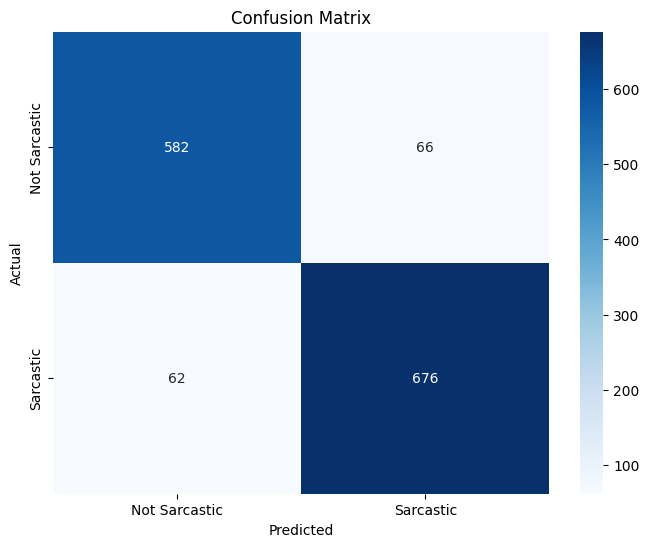

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##Testing the model with texts

In [ ]:
new_text = "My name is Jiya."
result = predict_sarcasm(new_text, tokenizer, model, max_len)
print(result)

1/1 [==============================] - 0s 41ms/step
This text is predicted to be non-sarcastic.


In [ ]:
new_text = "This new restaurant is a real gem, NOT."
result = predict_sarcasm(new_text, tokenizer, model, max_len)
print(result)

1/1 [==============================] - 0s 83ms/step
This text is predicted to be sarcastic.


In [ ]:
new_text = "My mom asked me this question as well."
result = predict_sarcasm(new_text, tokenizer, model, max_len)
print(result)

1/1 [==============================] - 0s 23ms/step
This text is predicted to be non-sarcastic.


In [ ]:
new_text = "Great job! You’ve managed to make things worse than before."
result = predict_sarcasm(new_text, tokenizer, model, max_len)
print(result)

1/1 [==============================] - 0s 35ms/step
This text is predicted to be sarcastic.


In [ ]:
new_text = "Sure, let's just add this to my already overflowing to-do list."
result = predict_sarcasm(new_text, tokenizer, model, max_len)
print(result)

1/1 [==============================] - 0s 61ms/step
This text is predicted to be sarcastic.


Verifing whether the prediction is same for same text which is tested Twice

In [ ]:
new_text = "Sure, let's just add this to my already overflowing to-do list."
result = predict_sarcasm(new_text, tokenizer, model, max_len)
print(result)

1/1 [==============================] - 0s 41ms/step
This text is predicted to be sarcastic.


#CONCLUSION:
###Data Preprocessing:
Loaded the dataset and displayed basic information.
Merged two dataset

Cleaned the data by removing @,# and URLs and also emojis.

###Encoded and Tokenized the labels.
###Handled Imbalanced Data
Applied Word Tokenization to the 'Tweet' column of our dataset

###Evaluating the Model:
Trained the Models, We explored different DL Models and found CNN to have the best accuracy-90.76%. Evaluated the model using classification report, confusion matrix, and accuracy score. tested the model with new random tweets.
